In [50]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from exp.nb_Tesis import *

In [52]:
# !wget https://challenge.kitware.com/api/v1/item/5ac37a9d56357d4ff856e176/download

In [53]:
# !wget https://challenge.kitware.com/api/v1/item/5ac3695656357d4ff856e16a/download

In [54]:
# !unzip seg_data/download.1

In [55]:
path = Path('./seg_data')

In [56]:
path_lbl = path/'modified_labels'
path_img = path/'images'

In [57]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('seg_data/images/ISIC_0000331.jpg'),
 PosixPath('seg_data/images/ISIC_0012272.jpg'),
 PosixPath('seg_data/images/ISIC_0013962.jpg')]

In [58]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('seg_data/modified_labels/ISIC_0013670_segmentation.png'),
 PosixPath('seg_data/modified_labels/ISIC_0015284_segmentation.png'),
 PosixPath('seg_data/modified_labels/ISIC_0013808_segmentation.png')]

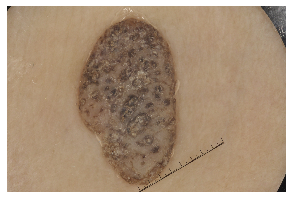

In [59]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))


In [60]:
img.shape

torch.Size([3, 2848, 4288])

In [61]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_segmentation.png'

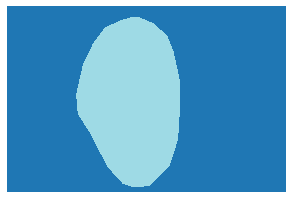

In [62]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [63]:
src_size = np.array(mask.shape[1:])
src_size,mask

(array([2848, 4288]), ImageSegment (1, 2848, 4288))

In [64]:
mask.data.unique()

tensor([0, 1])

In [65]:
codes = ['Lession', 'Other']

# Load the data

In [82]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [83]:
# size = src_size//10
size = 284

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 5596MB of GPU RAM free


In [84]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [85]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=8)
        .normalize())

In [21]:
bs

4

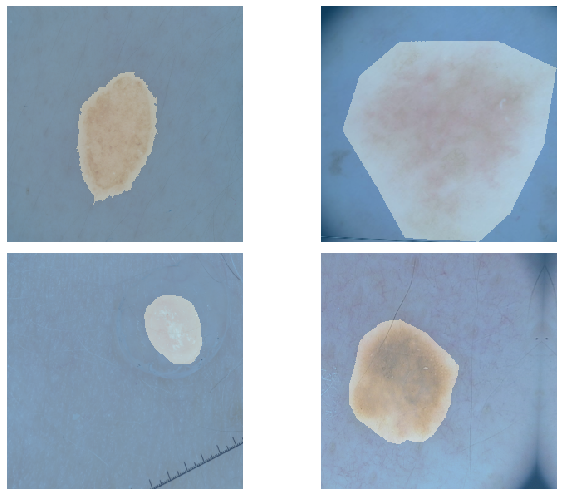

In [22]:
data.show_batch(2, figsize=(10,7))

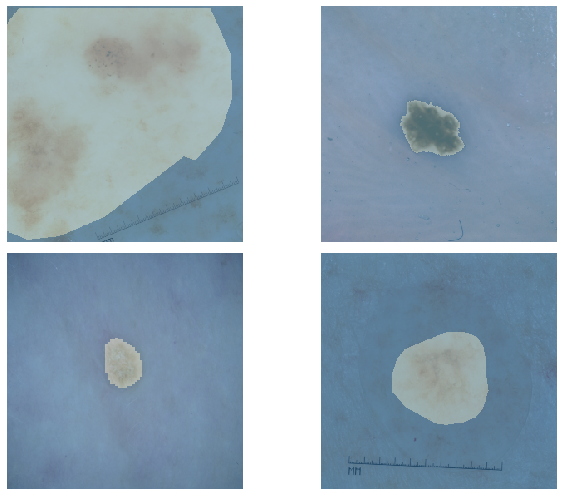

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

#### reset memory

In [24]:
torch.cuda.empty_cache()
gc.collect()

22345

In [25]:
# del learn
# del data

In [ ]:
!export CUDA_VISIBLE_DEVICES=1

In [86]:
!nvidia-smi

Mon Nov 25 17:46:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   38C    P2    56W / 250W |   5581MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
|  0%   23C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

#### define accuracy

In [70]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Other']

def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [71]:
metrics=acc_camvid
# metrics=accuracy

In [87]:
wd=1e-2

In [88]:
learn = unet_learner(data, 
                     models.resnet34,metrics=[dice],
                     callback_fns=[
                         ShowGraph,
                         ActivationStats,
                     ], 
                     wd=wd)

In [89]:
lr=3e-3

In [34]:
# del learn
# del data

torch.cuda.empty_cache()
gc.collect()

20

epoch,train_loss,valid_loss,dice,time
0,0.324909,0.237708,0.801351,02:55
1,0.247476,0.186601,0.835187,03:02


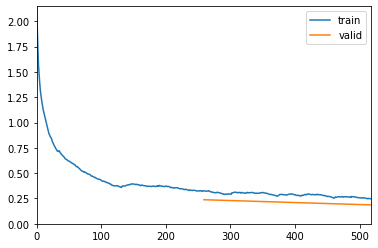

Better model found at epoch 0 with valid_loss value: 0.23770804703235626.
Better model found at epoch 1 with valid_loss value: 0.18660137057304382.


In [90]:
learn.fit_one_cycle(2, slice(3e-4), pct_start=0.9,callbacks = [
    SaveModelCallback(learn=learn),
    ReduceLROnPlateauCallback(learn=learn)
])

In [ ]:
# model_summary(learn)
learn.show_results??

In [29]:
learn.save('stage-1')

In [43]:
learn.load('bestmodel');

In [79]:
learn.show_results??

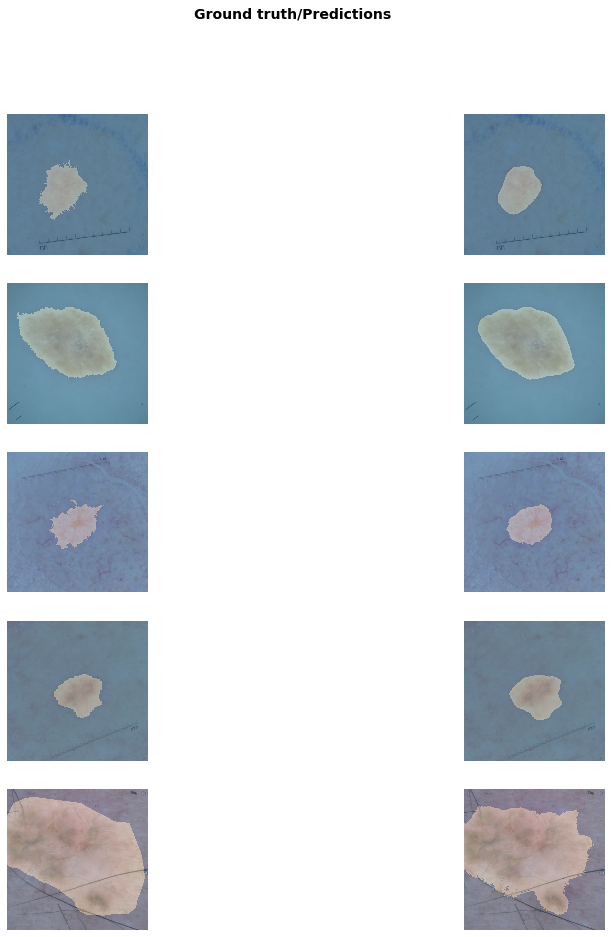

In [94]:
learn.show_results(rows=5, figsize=(15,15))

In [91]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

epoch,train_loss,valid_loss,dice,time
0,0.216618,0.177650,0.838539,03:01
1,0.195182,0.171975,0.844011,03:01
2,0.196613,0.162251,0.852972,03:02
3,0.176518,0.152567,0.863990,02:59
4,0.165838,0.171853,0.850808,03:00
5,0.182041,0.144225,0.871292,03:04
6,0.160288,0.145658,0.876860,03:04
7,0.140131,0.168695,0.860394,03:04
8,0.131382,0.141614,0.881555,03:00
9,0.113010,0.141585,0.886841,02:59


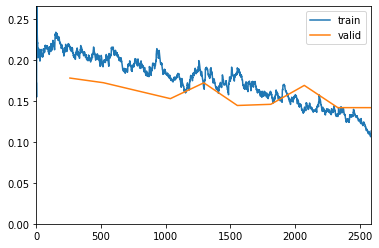

Better model found at epoch 0 with valid_loss value: 0.17765045166015625.
Better model found at epoch 1 with valid_loss value: 0.171974778175354.
Better model found at epoch 2 with valid_loss value: 0.16225063800811768.
Better model found at epoch 3 with valid_loss value: 0.15256677567958832.
Epoch 4: reducing lr to 1.4073760950704862e-05
Better model found at epoch 5 with valid_loss value: 0.14422494173049927.
Epoch 6: reducing lr to 1.9269243512108354e-05
Epoch 7: reducing lr to 1.9999999999999998e-05
Better model found at epoch 8 with valid_loss value: 0.14161434769630432.
Better model found at epoch 9 with valid_loss value: 0.1415853351354599.


In [92]:
learn.fit_one_cycle(10, slice(1e-6,1e-4), pct_start=0.8,callbacks = [
    SaveModelCallback(learn=learn),
    ReduceLROnPlateauCallback(learn=learn)
])

In [49]:
learn.load('bestmodel');

In [50]:
learn.export(file='square_segmenter.pkl')

/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DynamicUnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj._